<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/main_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Recognition of Digits within Images of Sudoku Cells

## Utility Methods (please outsource this)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import math
import random

def show_images(images, titles=None, cmap=None, rows=None, columns=None, scaling=(5, 5), n_samples=None, i_samples=None, autoscale=False):
  assert not (n_samples is not None and i_samples is not None)

  if titles is None:
    titles = ["[%d]" % i for i in range(len(images))]
  
  if n_samples is not None:
    indices = random.sample(range(len(images)), n_samples)
    images = [images[i] for i in indices]
    titles = [titles[i] for i in indices] 
  elif i_samples is not None:
    images = [images[i] for i in i_samples]
    titles = [titles[i] for i in i_samples]
  
  if rows is None and columns is None:
    rows = math.ceil(math.sqrt(len(images)))
  if rows is None:
    rows = math.ceil(len(images) / columns)
  if columns is None:
    columns = math.ceil(len(images) / rows)

  plt.figure(figsize=(scaling[1] * columns, scaling[0] * rows))
  for i, image in enumerate(images):
    if len(image.shape) == 3 and image.shape[-1] == 1:
      # assume grayscale image with single channel has been passed
      # matplotlib does not like that
      image = image.reshape(image.shape[:-1])
    if not autoscale and image.dtype.name.startswith("uint"):
      normalizer = matplotlib.colors.Normalize(vmin=0, vmax=255)
    elif not autoscale and image.dtype.name.startswith("float"):
      normalizer = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
    else:
      normalizer = matplotlib.colors.Normalize()
    plt.subplot(rows, columns, i + 1)
    plt.title(titles[i])
    plt.imshow(image, cmap=cmap, norm=normalizer)
  plt.tight_layout()
  plt.show()

## Acquire dataset of images and labels

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/dataset_digits.zip" "./dataset_digits.zip"

In [4]:
!unzip "./dataset_digits.zip"

Archive:  ./dataset_digits.zip
   creating: digits/
   creating: digits/2/
 extracting: digits/2/9581.png       
 extracting: digits/2/10507.png      
 extracting: digits/2/10919.png      
 extracting: digits/2/7358.png       
 extracting: digits/2/6503.png       
 extracting: digits/2/11357.png      
 extracting: digits/2/5189.png       
 extracting: digits/2/903.png        
 extracting: digits/2/6323.png       
 extracting: digits/2/12231.png      
 extracting: digits/2/3843.png       
 extracting: digits/2/3234.png       
 extracting: digits/2/3513.png       
 extracting: digits/2/10725.png      
 extracting: digits/2/9208.png       
 extracting: digits/2/11195.png      
 extracting: digits/2/10588.png      
 extracting: digits/2/258.png        
 extracting: digits/2/6336.png       
 extracting: digits/2/11557.png      
 extracting: digits/2/9310.png       
 extracting: digits/2/8234.png       
 extracting: digits/2/4019.png       
 extracting: digits/2/2707.png       
 extracting: 

In [29]:
import os
import skimage.io as io

X = []
Y = []

for digit in range(10):
  digit_path = os.path.join("./digits", str(digit))
  for image_filename in os.listdir(digit_path):
    if not image_filename.endswith(".png"):
      continue
    image_filename = os.path.join(digit_path, image_filename)
    image = io.imread(image_filename)
    X.append(image)
    Y.append(digit)
  print("Read", sum([1 if y == digit else 0 for y in Y]), "samples for digit", digit)

X = np.array(X)
Y = np.array(Y)

Read 5637 samples for digit 0
Read 771 samples for digit 1
Read 739 samples for digit 2
Read 762 samples for digit 3
Read 700 samples for digit 4
Read 722 samples for digit 5
Read 787 samples for digit 6
Read 718 samples for digit 7
Read 735 samples for digit 8
Read 741 samples for digit 9


In [0]:
indices = np.random.permutation(len(X))
indices_train, indices_test = np.split(indices, [int(len(X) * 0.75)])
X_train, X_test = X[indices_train], X[indices_test]
Y_train, Y_test = Y[indices_train], Y[indices_test]

## Recognize digits using neural networks

### Plain MNIST

#### Acquire dataset

In [7]:
from keras.datasets import mnist
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


In [8]:
print("Train:", mnist_x_train.shape, mnist_y_train.shape)
print("Test:", mnist_x_test.shape, mnist_y_test.shape)

Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)


In [0]:
mnist_x_train = mnist_x_train.astype("float32") / 255.0
mnist_x_test = mnist_x_test.astype("float32") / 255.0

In [0]:
mnist_x_train = mnist_x_train.reshape(-1, 28, 28, 1)
mnist_x_test = mnist_x_test.reshape(-1, 28, 28, 1)

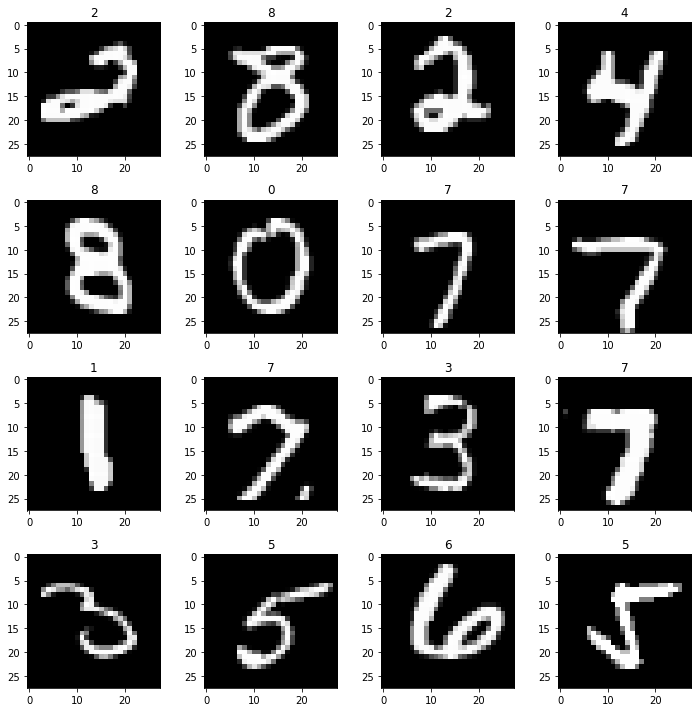

In [11]:
show_images(mnist_x_train, mnist_y_train, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

#### Building the model

In [13]:
from keras import models, layers

plainmnist_model = model_input = layers.Input(shape=(28, 28, 1))

plainmnist_model = layers.Conv2D(16, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Conv2D(32, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.MaxPool2D()(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Dropout(0.25)(plainmnist_model)

plainmnist_model = layers.Conv2D(64, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Conv2D(128, 3, activation="relu")(plainmnist_model)
plainmnist_model = layers.GlobalMaxPool2D()(plainmnist_model)
plainmnist_model = layers.BatchNormalization()(plainmnist_model)
plainmnist_model = layers.Dropout(0.25)(plainmnist_model)

#model = layers.Flatten()(model)
#model = layers.Dense(32, activation="relu")(model)
#model = layers.BatchNormalization()(model)
plainmnist_model = layers.Dense(10, activation="softmax")(plainmnist_model)
plainmnist_model = models.Model(model_input, plainmnist_model)
plainmnist_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
plainmnist_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_5 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)        0   

#### Fitting the model

In [14]:
from keras import callbacks
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
fit_history = plainmnist_model.fit(mnist_x_train, mnist_y_train, validation_data=(mnist_x_test, mnist_y_test), epochs=100, callbacks=[early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 23s 382us/step - loss: 0.1685 - acc: 0.9492 - val_loss: 0.0438 - val_acc: 0.9855
Epoch 2/100
60000/60000 [==============================] - 16s 262us/step - loss: 0.0662 - acc: 0.9795 - val_loss: 0.0379 - val_acc: 0.9873
Epoch 3/100
60000/60000 [==============================] - 16s 273us/step - loss: 0.0522 - acc: 0.9834 - val_loss: 0.0258 - val_acc: 0.9913
Epoch 4/100
60000/60000 [==============================] - 16s 262us/step - loss: 0.0460 - acc: 0.9855 - val_loss: 0.0212 - val_acc: 0.9927
Epoch 5/100
60000/60000 [==============================] - 16s 259us/step - loss: 0.0389 - acc: 0.9876 - val_loss: 0.0212 - val_acc: 0.9933
Epoch 6/100
60000/60000 [==============================] - 15s 258us/step - loss: 0.0359 - acc: 0.9883 - val_loss: 0.0221 - val_acc: 0.9928
Epoch 7/100
60

In [16]:
plainmnist_model.evaluate(mnist_x_test, mnist_y_test)

10000/10000 [==============================] - 1s 58us/step


[0.016793228912288034, 0.9936]

#### Visualizing the model

Visualizing test image 9034


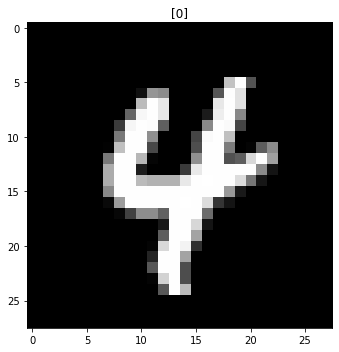

Visualizing layer #1 (conv2d_5)


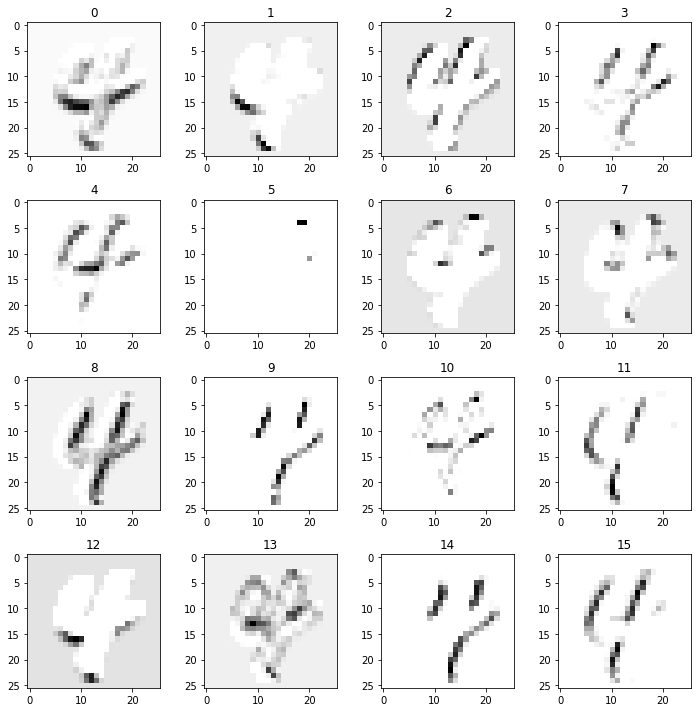

Visualizing layer #3 (conv2d_6)


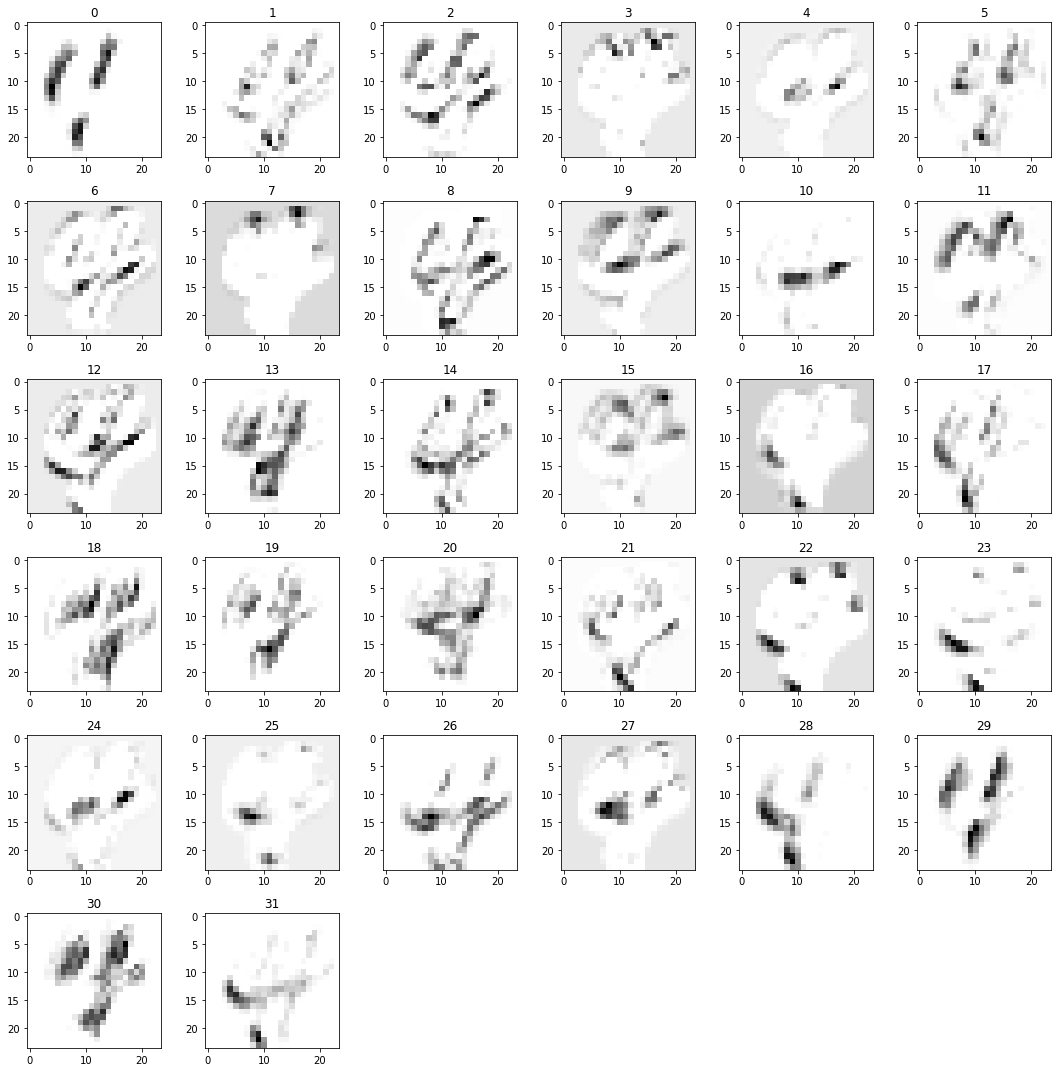

Visualizing layer #7 (conv2d_7)


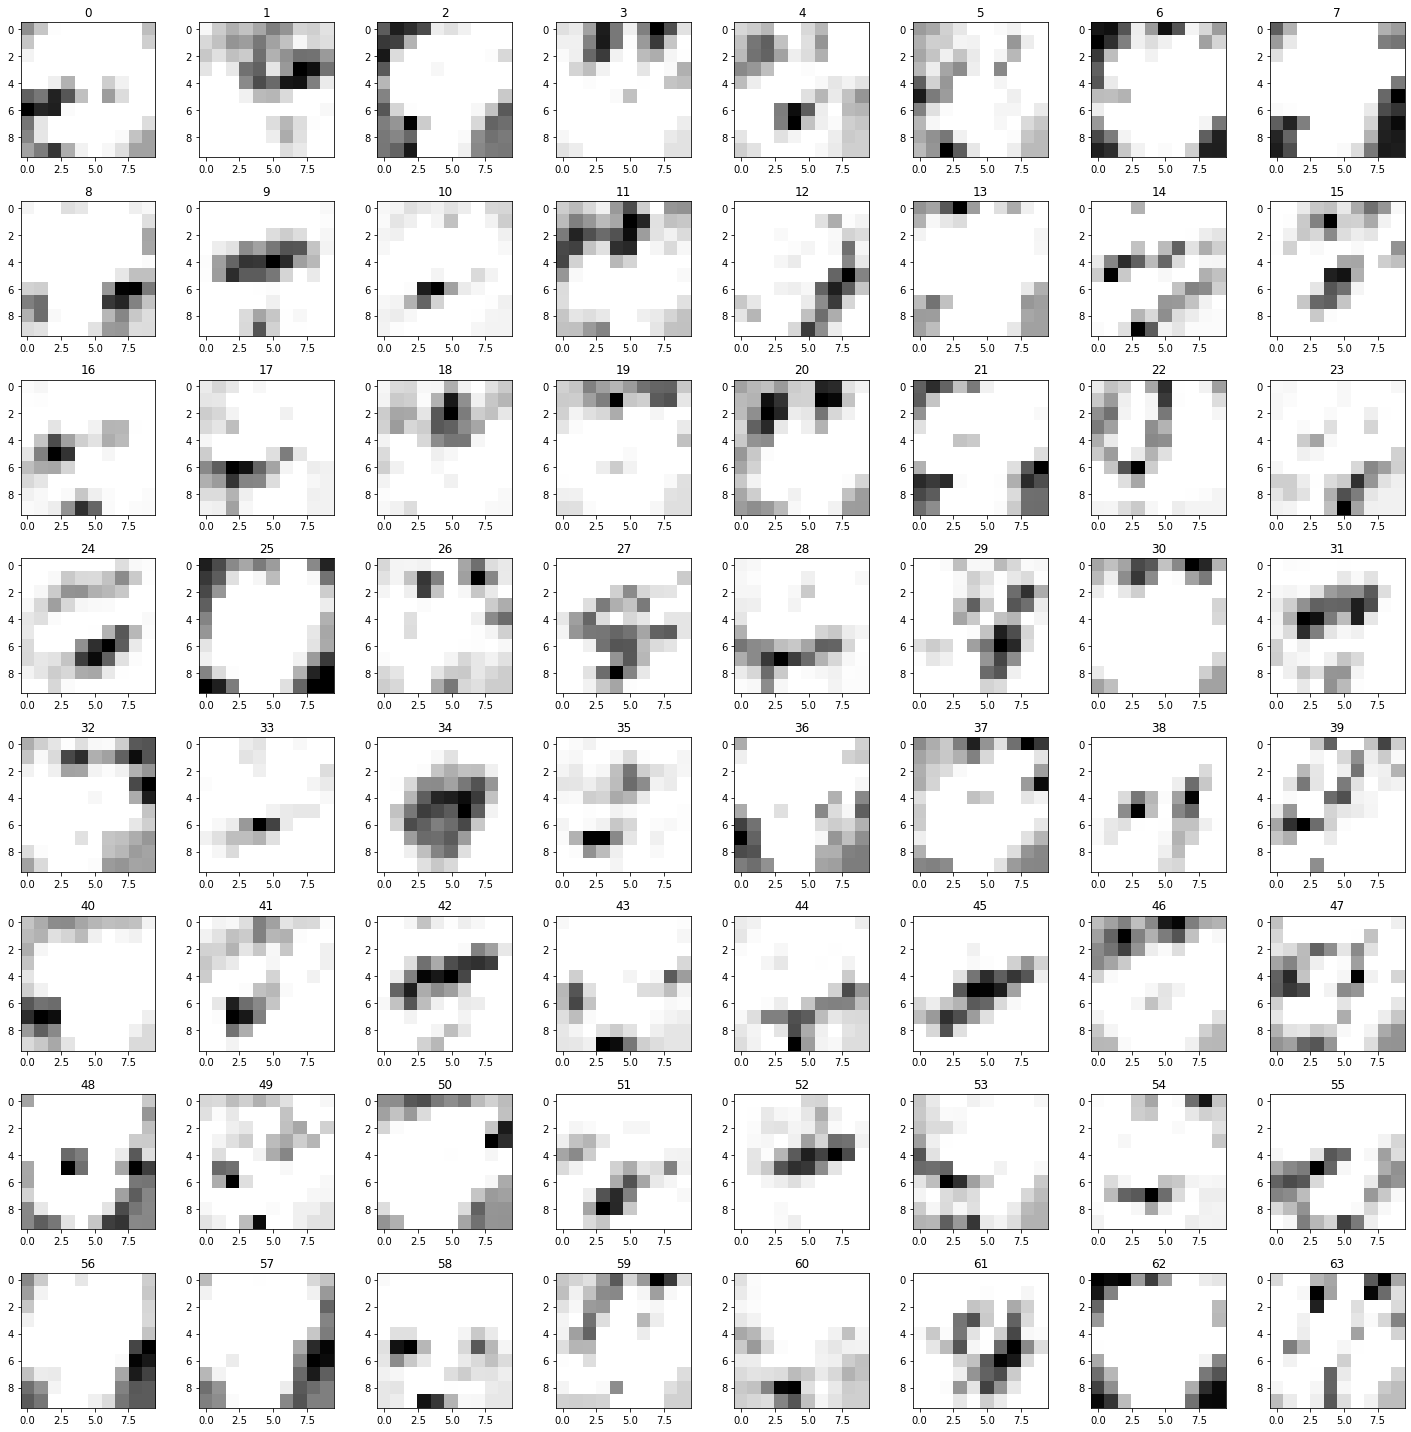

Visualizing layer #9 (conv2d_8)


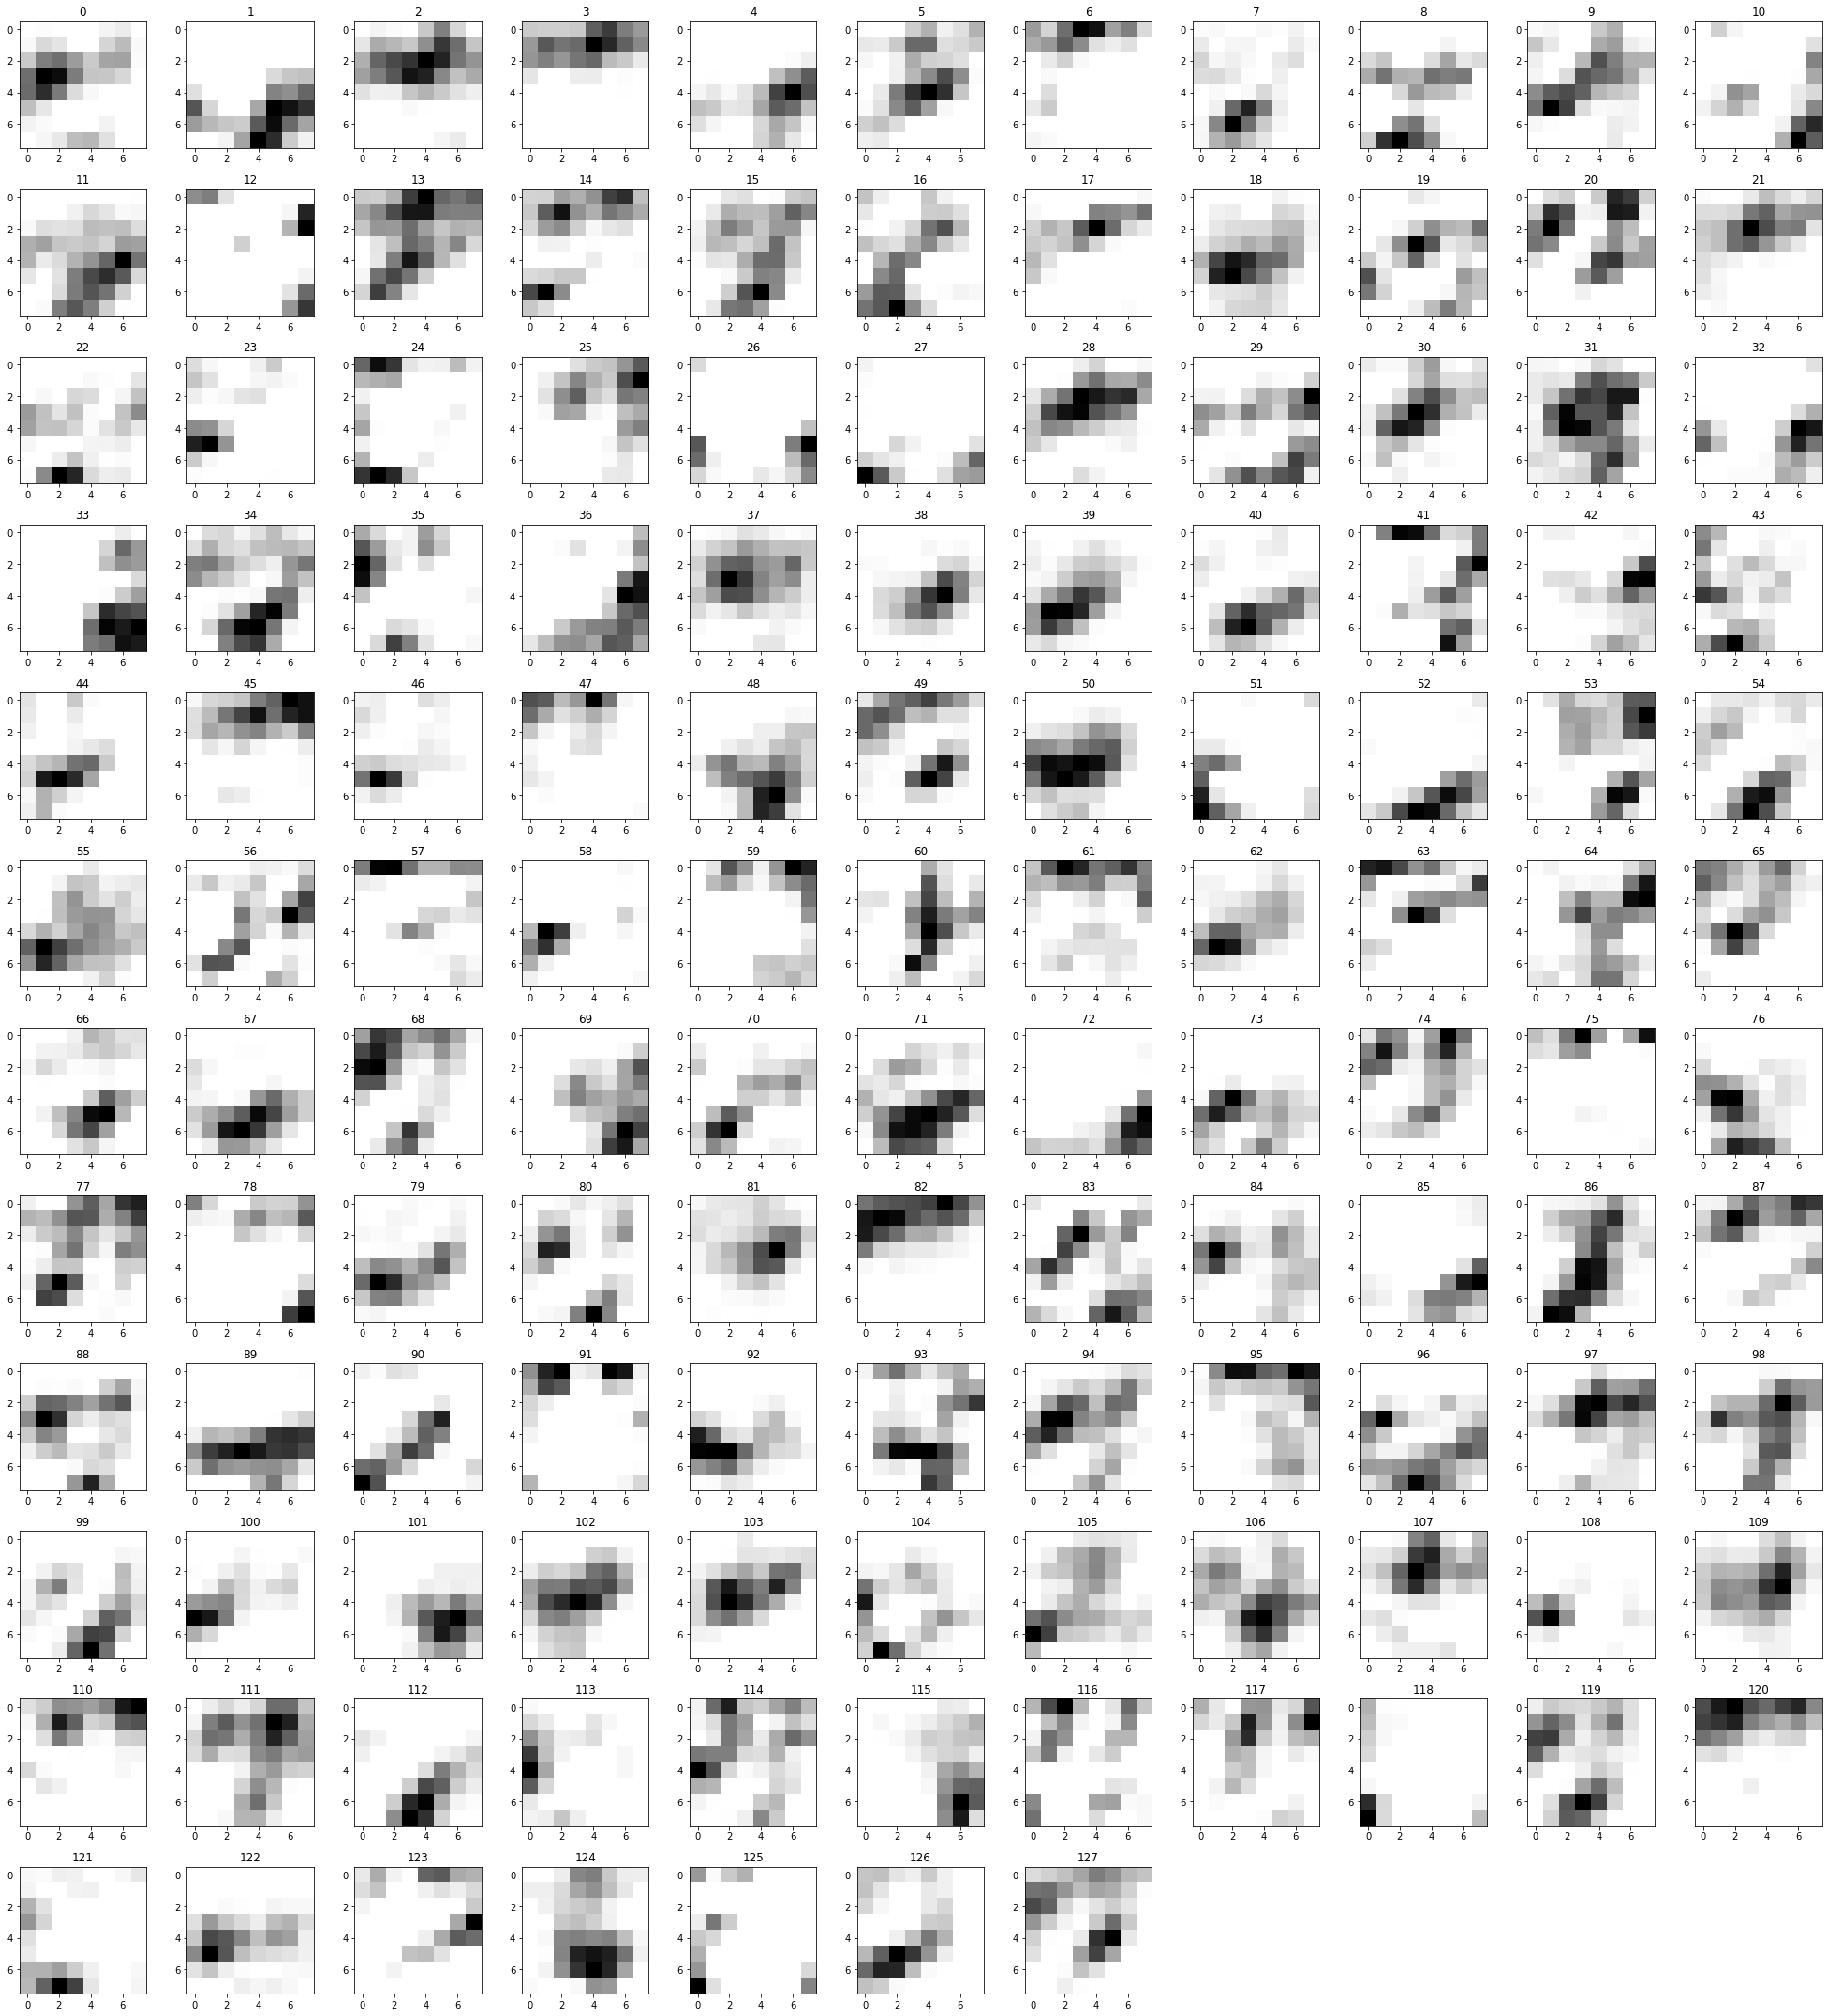

In [19]:
index = random.choice(range(len(mnist_x_test)))
print("Visualizing test image", index)
image = mnist_x_test[index]
show_images([image], cmap="gray")

def nn_get_submodel(model, layer):
  return models.Model(model.input, model.layers[layer].output)

def nn_visualize_layer_activations(model, layer, input):
  submodel = nn_get_submodel(model, layer)
  activations = submodel.predict(np.expand_dims(input, 0))[0]
  activation_channels = np.arange(activations.shape[-1])
  activation_images = [activations[:,:,i] for i in activation_channels]
  show_images(activation_images, activation_channels, cmap="Greys", scaling=(2.5, 2.5), autoscale=True)

for i_layer, layer in enumerate(plainmnist_model.layers):
  if layer.name.startswith("conv2d") and len(layer.output.shape) == 4:
    print("Visualizing layer #%d (%s)" % (i_layer, layer.name))
    nn_visualize_layer_activations(plainmnist_model, i_layer, image)

#### Evaluating the model

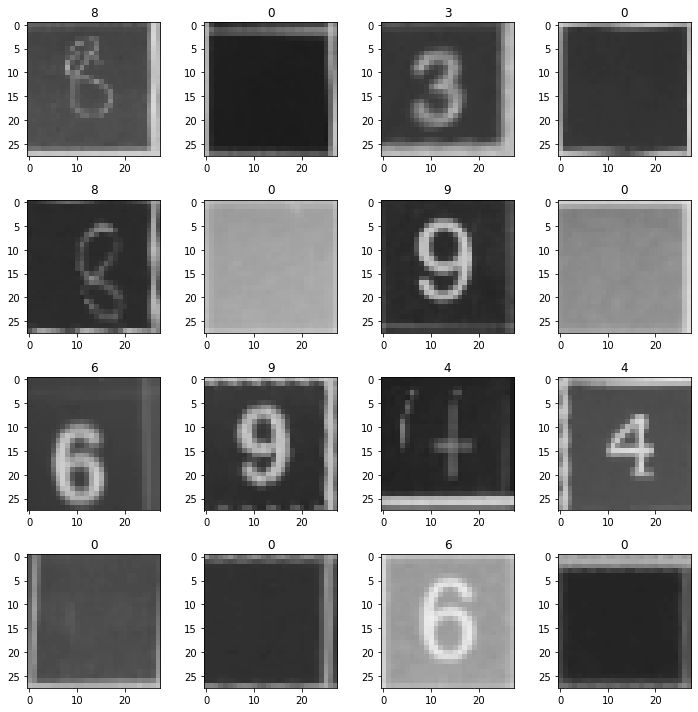

In [36]:
import cv2 as cv

def nn_mnist_preprocess(cell):
  # convert to grayscale
  cell = cv.cvtColor(cell, cv.COLOR_RGB2GRAY)
  # invert:
  cell = 255 - cell
  # resize:
  cell = cv.resize(cell, (28, 28), cv.INTER_AREA)
  # normalize:
  cell = cell.astype("float32") / 255.0
  # expand dims:
  cell = np.expand_dims(cell, axis=2)
  return cell

X_train_plainmnist = np.array([nn_mnist_preprocess(x) for x in X_train])
X_test_plainmnist = np.array([nn_mnist_preprocess(x) for x in X_test])
Y_train_plainmnist = Y_train
Y_test_plainmnist = Y_test
show_images(X_train_plainmnist, Y_train_plainmnist, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

In [37]:
plainmnist_model.evaluate(X_test_plainmnist, Y_test_plainmnist)

3078/3078 [==============================] - 0s 74us/step


[10.397329001398811, 0.0792722547108512]

In [40]:
from sklearn.metrics import classification_report
Y_pred_plainmnist = plainmnist_model.predict(X_test_plainmnist)
print(classification_report(Y_test_plainmnist, np.argmax(Y_pred_plainmnist, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1429
           1       0.07      1.00      0.13       195
           2       0.00      0.00      0.00       181
           3       0.00      0.00      0.00       180
           4       1.00      0.02      0.04       183
           5       1.00      0.01      0.01       177
           6       1.00      0.00      0.01       209
           7       0.00      0.00      0.00       165
           8       0.24      0.25      0.25       172
           9       0.00      0.00      0.00       187

    accuracy                           0.08      3078
   macro avg       0.33      0.13      0.04      3078
weighted avg       0.20      0.08      0.03      3078



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Augmented MNIST

#### Acquire dataset

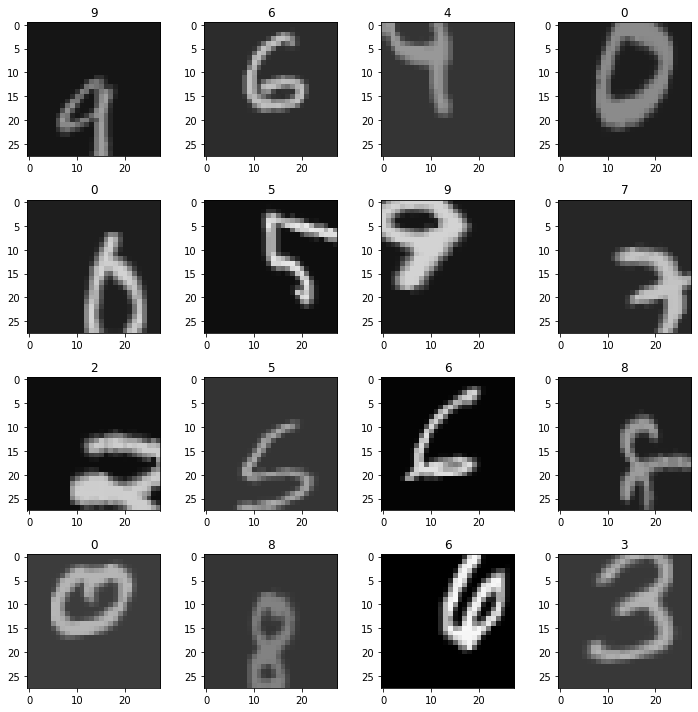

In [41]:
import PIL

def augmnist_change_brightness(image, factor):
  return image * factor

def augmnist_change_contrast(image, factor):
  return 0.5 + factor * (image - 0.5)

def augmnist_preprocess(image):
  image = image[:,:,0]
  factor = np.random.rand() * 0.5 + 0.5
  image = augmnist_change_brightness(image, factor)
  factor = np.random.rand() * 0.5 + 0.5
  image = augmnist_change_contrast(image, factor)
  # if np.random.rand() < 0.5:
  #   kernel = np.ones((np.random.randint(3), np.random.randint(3)))
  #   image = cv.erode(image, kernel)
  # else:
  #   kernel = np.ones((np.random.randint(3), np.random.randint(3)))
  #   image = cv.dilate(image, kernel)
  return np.expand_dims(image, axis=2)

from keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(width_shift_range=0.25, height_shift_range=0.25, zoom_range=0.25, shear_range=22.5, preprocessing_function=augmnist_preprocess)
augmnist_generator_train = generator.flow(mnist_x_train, mnist_y_train)
augmnist_generator_test = generator.flow(mnist_x_test, mnist_y_test)
show_images(*augmnist_generator_train[0], cmap="gray", scaling=(2.5, 2.5), n_samples=16)

#### Building the model

In [42]:
from keras import models, layers

augmnist_model = model_input = layers.Input(shape=(28, 28, 1))

augmnist_model = layers.Conv2D(16, 3, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Conv2D(32, 3, activation="relu")(augmnist_model)
augmnist_model = layers.MaxPool2D()(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Dropout(0.25)(augmnist_model)

augmnist_model = layers.Conv2D(64, 3, activation="relu")(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Conv2D(128, 3, activation="relu")(augmnist_model)
augmnist_model = layers.GlobalMaxPool2D()(augmnist_model)
augmnist_model = layers.BatchNormalization()(augmnist_model)
augmnist_model = layers.Dropout(0.25)(augmnist_model)

#model = layers.Flatten()(model)
#model = layers.Dense(32, activation="relu")(model)
#model = layers.BatchNormalization()(model)
augmnist_model = layers.Dense(10, activation="softmax")(augmnist_model)
augmnist_model = models.Model(model_input, augmnist_model)
augmnist_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
augmnist_model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_9 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 32)        0  

#### Fitting the model

In [43]:
from keras import callbacks
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
fit_history = augmnist_model.fit_generator(augmnist_generator_train, validation_data=augmnist_generator_test, epochs=100, callbacks=[early_stopping])

Epoch 1/100
1875/1875 [==============================] - 31s 16ms/step - loss: 0.5116 - acc: 0.8395 - val_loss: 0.1644 - val_acc: 0.9489
Epoch 2/100
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2235 - acc: 0.9318 - val_loss: 0.1138 - val_acc: 0.9648
Epoch 3/100
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1787 - acc: 0.9452 - val_loss: 0.1499 - val_acc: 0.9515
Epoch 4/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1553 - acc: 0.9525 - val_loss: 0.0998 - val_acc: 0.9671
Epoch 5/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1438 - acc: 0.9562 - val_loss: 0.0810 - val_acc: 0.9737
Epoch 6/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1337 - acc: 0.9590 - val_loss: 0.0820 - val_acc: 0.9756
Epoch 7/100
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1275 - acc: 0.9616 - val_loss: 0.0727 - val_acc: 0.9776
Epoch 8/100
1875/1875 [==================

#### Evaluating the model

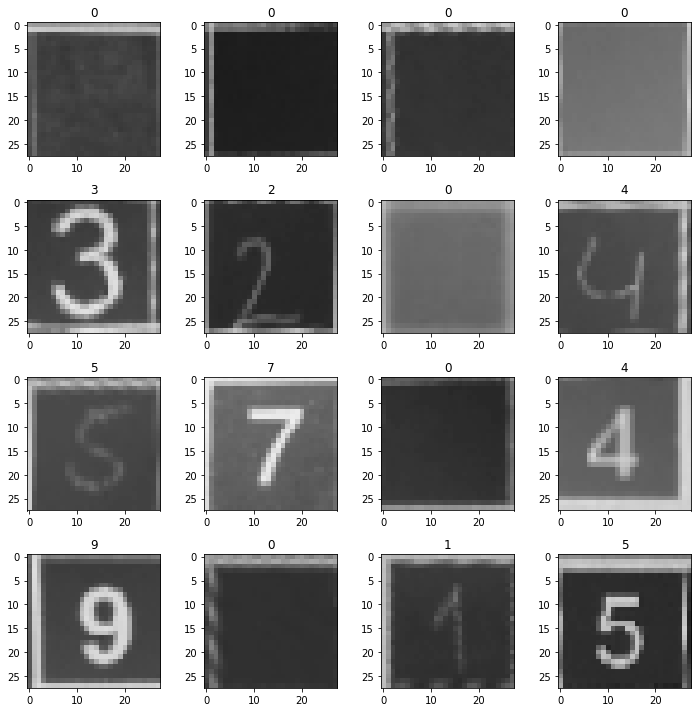

In [47]:
X_train_augmnist = np.array([nn_mnist_preprocess(x) for x in X_train])
X_test_augmnist = np.array([nn_mnist_preprocess(x) for x in X_test])
Y_train_augmnist = Y_train
Y_test_augmnist = Y_test
show_images(X_test_augmnist, Y_test_augmnist, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

In [48]:
augmnist_model.evaluate(X_test_augmnist, Y_test_augmnist)

3078/3078 [==============================] - 0s 66us/step


[1.9000129409236053, 0.4606887589537377]

In [49]:
from sklearn.metrics import classification_report
Y_pred_augmnist = augmnist_model.predict(X_test_augmnist)
print(classification_report(Y_test_augmnist, np.argmax(Y_pred_augmnist, axis=1)))

              precision    recall  f1-score   support

           0       0.77      0.29      0.42      1429
           1       0.14      0.35      0.20       195
           2       0.51      0.65      0.57       181
           3       0.56      0.89      0.69       180
           4       0.44      0.66      0.53       183
           5       0.61      0.85      0.71       177
           6       0.57      0.43      0.49       209
           7       0.20      0.56      0.29       165
           8       0.56      0.90      0.69       172
           9       0.49      0.29      0.37       187

    accuracy                           0.46      3078
   macro avg       0.48      0.59      0.50      3078
weighted avg       0.60      0.46      0.46      3078



### Sudoku datasets


#### Acquire dataset

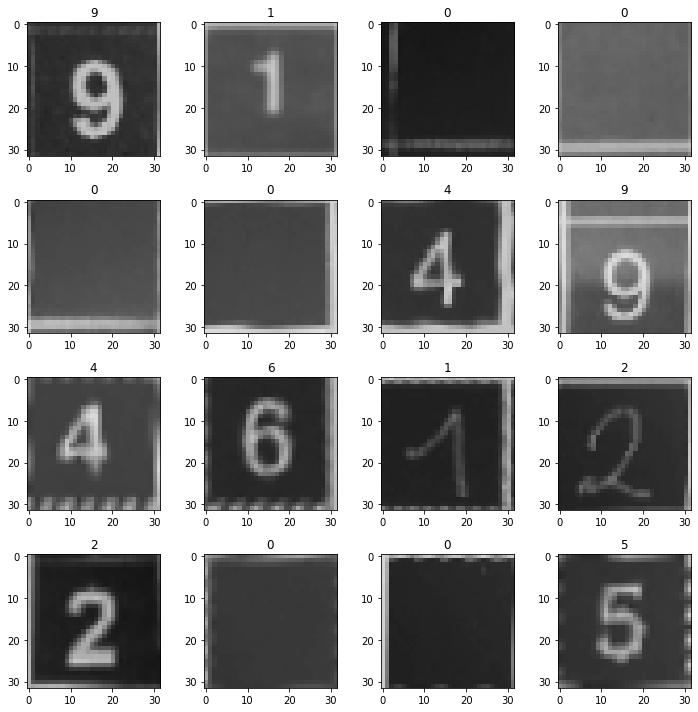

In [50]:
def sudnn_preprocess(cell):
  # convert to grayscale
  cell = cv.cvtColor(cell, cv.COLOR_RGB2GRAY)
  # invert:
  cell = 255 - cell
  # resize:
  cell = cv.resize(cell, (32, 32), cv.INTER_AREA)
  # normalize:
  cell = cell.astype("float32") / 255.0
  # expand dims:
  cell = np.expand_dims(cell, axis=2)
  return cell

X_train_sudnn = np.array([sudnn_preprocess(x) for x in X_train])
X_test_sudnn = np.array([sudnn_preprocess(x) for x in X_test])
Y_train_sudnn = Y_train
Y_test_sudnn = Y_test
show_images(X_train_sudnn, Y_train_sudnn, cmap="gray", scaling=(2.5, 2.5), n_samples=16)

#### Building the model

In [51]:
from keras import models, layers

sudnn_model = model_input = layers.Input(shape=(32, 32, 1))

sudnn_model = layers.Conv2D(8, 3, activation="relu")(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Conv2D(16, 3, activation="relu")(sudnn_model)
sudnn_model = layers.MaxPool2D()(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Dropout(0.25)(sudnn_model)

sudnn_model = layers.Conv2D(16, 3, activation="relu")(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Conv2D(32, 3, activation="relu")(sudnn_model)
sudnn_model = layers.GlobalMaxPool2D()(sudnn_model)
sudnn_model = layers.BatchNormalization()(sudnn_model)
sudnn_model = layers.Dropout(0.25)(sudnn_model)

#model = layers.Flatten()(model)
#model = layers.Dense(32, activation="relu")(model)
#model = layers.BatchNormalization()(model)
sudnn_model = layers.Dense(10, activation="softmax")(sudnn_model)
sudnn_model = models.Model(model_input, sudnn_model)
sudnn_model.compile("adam", "sparse_categorical_crossentropy", metrics=["acc"])
sudnn_model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 8)         80        
_________________________________________________________________
batch_normalization_13 (Batc (None, 30, 30, 8)         32        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 16)        1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 16)        0  

#### Fitting the model

In [53]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight("balanced", np.unique(Y_test_sudnn), Y_test_sudnn)
class_weight

array([0.21539538, 1.57846154, 1.70055249, 1.71      , 1.68196721,
       1.73898305, 1.47272727, 1.86545455, 1.78953488, 1.6459893 ])

In [55]:
from keras import callbacks
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
fit_history = sudnn_model.fit(X_train_sudnn, Y_train_sudnn, 
                              validation_data=(X_test_sudnn, Y_test_sudnn), 
                              epochs=100, callbacks=[early_stopping], 
                              class_weight=class_weight)

Train on 9234 samples, validate on 3078 samples
Epoch 1/100
9234/9234 [==============================] - 4s 431us/step - loss: 1.1330 - acc: 0.6480 - val_loss: 0.4929 - val_acc: 0.8642
Epoch 2/100
9234/9234 [==============================] - 3s 292us/step - loss: 0.4654 - acc: 0.8641 - val_loss: 0.2396 - val_acc: 0.9285
Epoch 3/100
9234/9234 [==============================] - 3s 293us/step - loss: 0.2865 - acc: 0.9142 - val_loss: 0.1586 - val_acc: 0.9535
Epoch 4/100
9234/9234 [==============================] - 3s 295us/step - loss: 0.2159 - acc: 0.9334 - val_loss: 0.1185 - val_acc: 0.9691
Epoch 5/100
9234/9234 [==============================] - 3s 292us/step - loss: 0.1717 - acc: 0.9487 - val_loss: 0.0997 - val_acc: 0.9740
Epoch 6/100
9234/9234 [==============================] - 3s 289us/step - loss: 0.1444 - acc: 0.9584 - val_loss: 0.0900 - val_acc: 0.9730
Epoch 7/100
9234/9234 [==============================] - 3s 286us/step - loss: 0.1269 - acc: 0.9604 - val_loss: 0.0661 - val_acc: 

#### Evaluating the model

In [56]:
sudnn_model.evaluate(X_test_sudnn, Y_test_sudnn)

3078/3078 [==============================] - 0s 65us/step


[0.015642635347787214, 0.9951267056530214]

In [57]:
Y_pred_sudnn = sudnn_model.predict(X_test_sudnn)
print(classification_report(Y_test_sudnn, np.argmax(Y_pred_sudnn, axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1429
           1       0.99      1.00      0.99       195
           2       1.00      0.99      0.99       181
           3       0.98      0.99      0.99       180
           4       1.00      0.98      0.99       183
           5       1.00      0.99      1.00       177
           6       1.00      1.00      1.00       209
           7       0.99      0.99      0.99       165
           8       0.98      0.99      0.99       172
           9       0.99      0.98      0.99       187

    accuracy                           1.00      3078
   macro avg       0.99      0.99      0.99      3078
weighted avg       1.00      1.00      1.00      3078



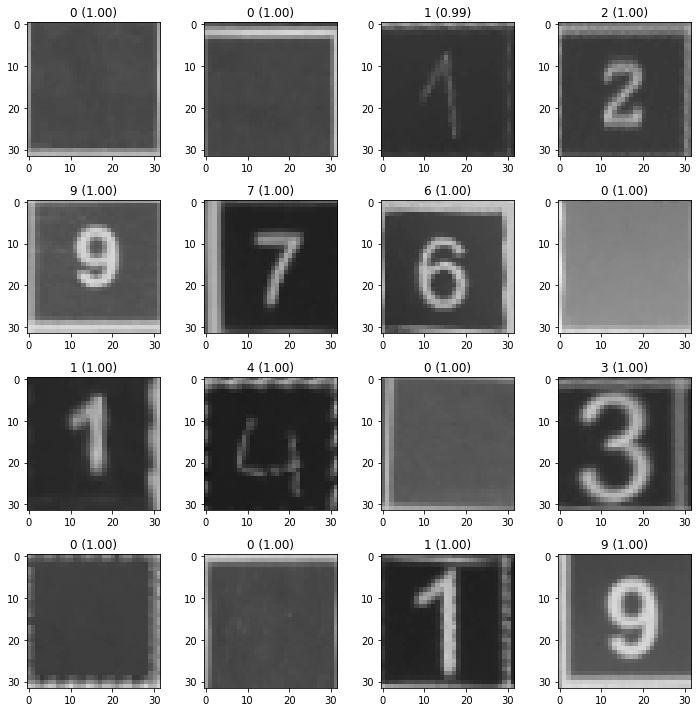

In [58]:
show_images(X_test_sudnn, ["%d (%0.2f)" % (np.argmax(pred), np.max(pred)) for pred in Y_pred_sudnn], cmap="gray", scaling=(2.5, 2.5), n_samples=16)